<a href="https://www.kaggle.com/code/idiotprofessor/loan-approval-prediction?scriptVersionId=207551549" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder,OrdinalEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [4]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

* **id** is applicant id
* **person**_age is age
* **person**_income is income
* **person**_home_ownership is status of home ownership
* **person_emp_length** is employment length (in years)
* **loan_intent** is loan intent
* **loan_grade** is loan grade
* **loan_amnt** is loan amount
* **loan_int_rate** is interest rate
* **loan_percent_income** is percent income
* **cb_person_default_on_file** is historical default
* **cb_person_cred_hist_length** is credit history length
* **loan_status is loan status** (0 is non; 1 is yes)

In [5]:
train_data.shape

(58645, 13)

In [6]:
test_data.shape

(39098, 12)

In [7]:
df = pd.concat([train_data, test_data], ignore_index=True)

In [8]:
df.shape

(97743, 13)

In [9]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0.0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0.0


# Checking Data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97743 entries, 0 to 97742
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          97743 non-null  int64  
 1   person_age                  97743 non-null  int64  
 2   person_income               97743 non-null  int64  
 3   person_home_ownership       97743 non-null  object 
 4   person_emp_length           97743 non-null  float64
 5   loan_intent                 97743 non-null  object 
 6   loan_grade                  97743 non-null  object 
 7   loan_amnt                   97743 non-null  int64  
 8   loan_int_rate               97743 non-null  float64
 9   loan_percent_income         97743 non-null  float64
 10  cb_person_default_on_file   97743 non-null  object 
 11  cb_person_cred_hist_length  97743 non-null  int64  
 12  loan_status                 58645 non-null  float64
dtypes: float64(4), int64(5), object

In [11]:
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,97743.000000,97743.000000,9.774300e+04,97743.000000,97743.000000,97743.000000,97743.000000,97743.000000,58645.000000
mean,48871.000000,27.557227,6.405189e+04,4.695436,9231.120663,10.671211,0.159372,5.820417,0.142382
std,28216.118018,6.033008,3.794080e+04,3.923469,5568.786009,3.028910,0.091668,4.046423,0.349445
min,0.000000,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,24435.500000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,48871.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,73306.500000,30.000000,7.574400e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,97742.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [12]:
df.isnull().sum()

id                                0
person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length                 0
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                     0
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
loan_status                   39098
dtype: int64

In [13]:
#removing id as it is not needed
df.drop(columns= 'id', inplace= True)

In [14]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0.0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0.0


In [15]:
#creating function for Histogram
def histplot(data, column, bins=30, title='Histogram', xlabel='Value', ylabel='Frequency'):
    plt.figure(figsize=(6,4))
    sns.histplot(data[column], bins=bins, kde=True)
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel(ylabel)
    plt.show()

# Checking data variation

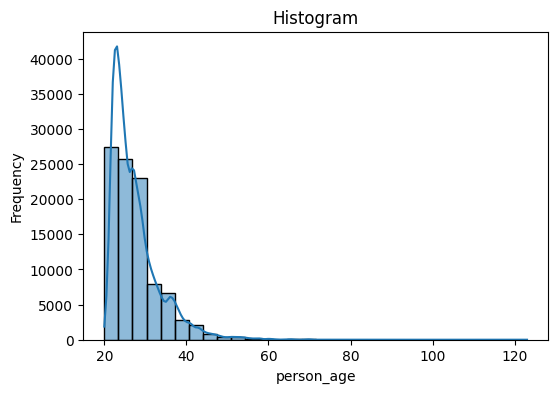

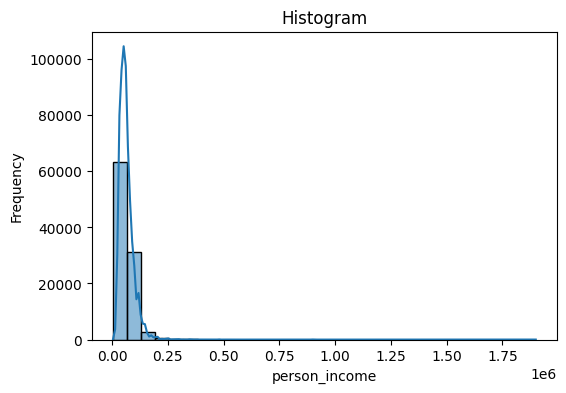

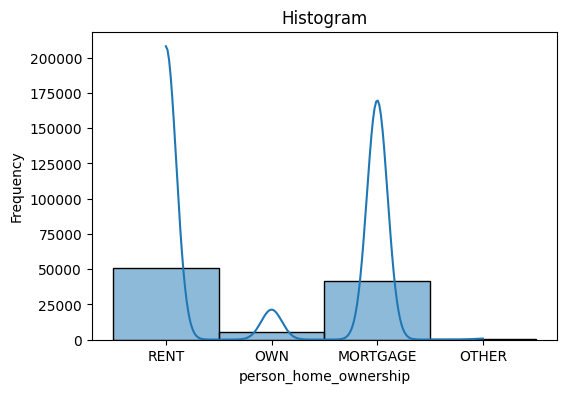

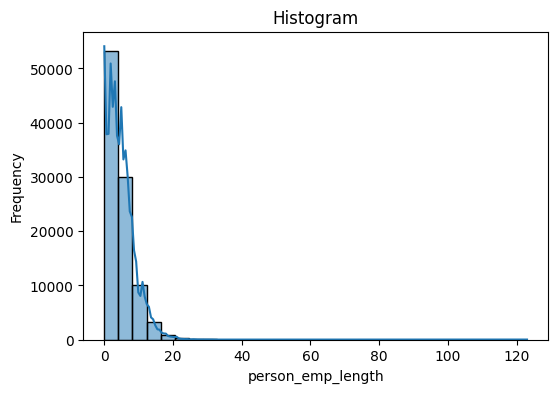

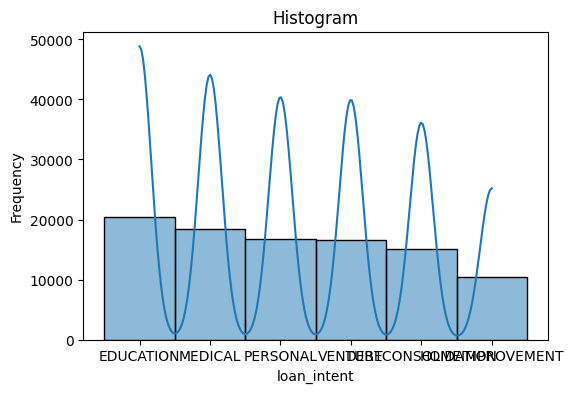

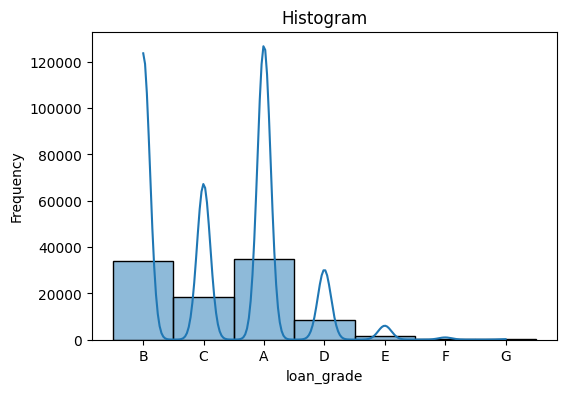

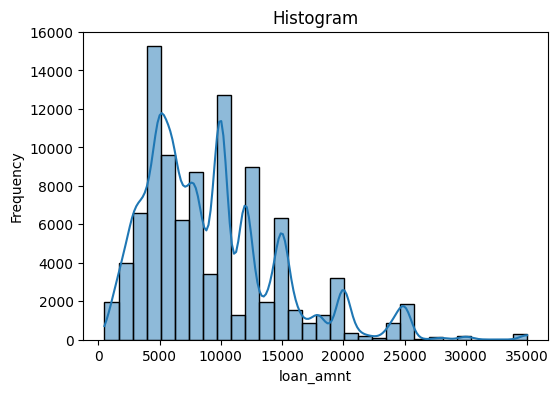

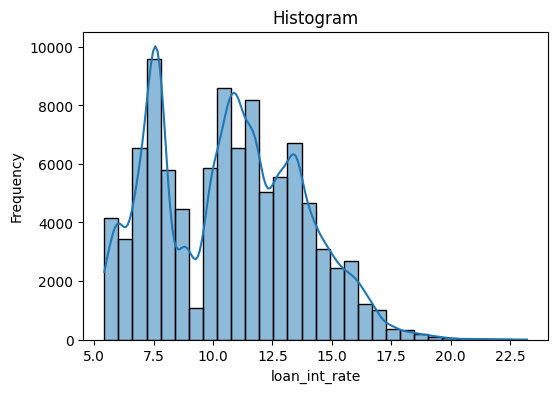

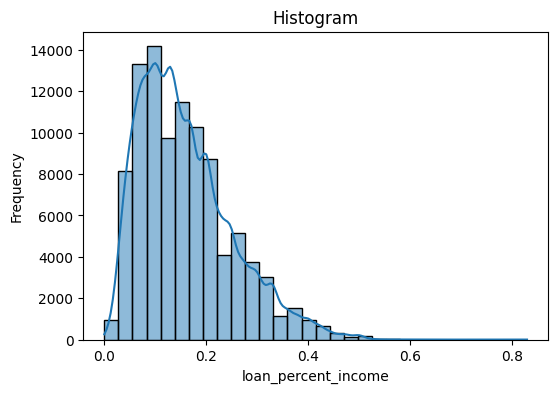

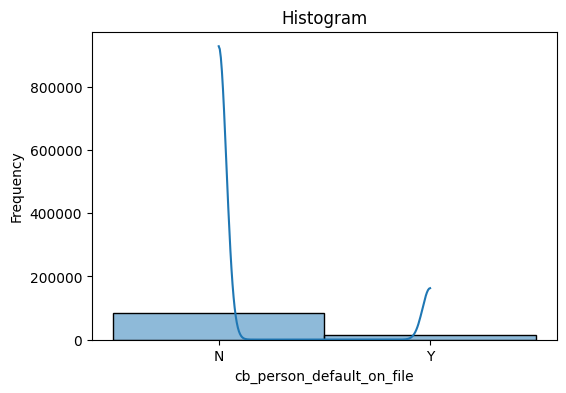

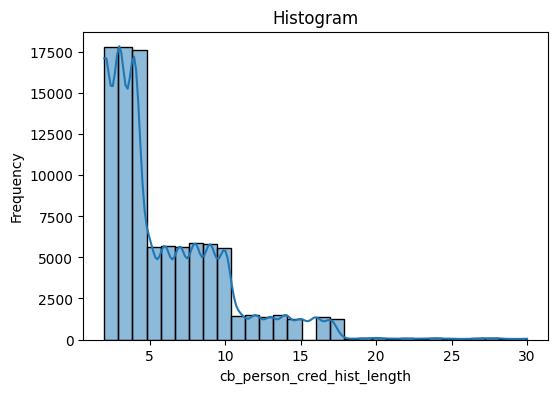

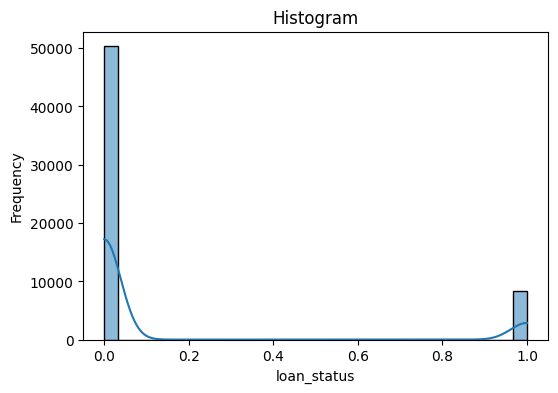

In [16]:
for col in df.columns:
    histplot(df, col)

<Axes: ylabel='cb_person_cred_hist_length'>

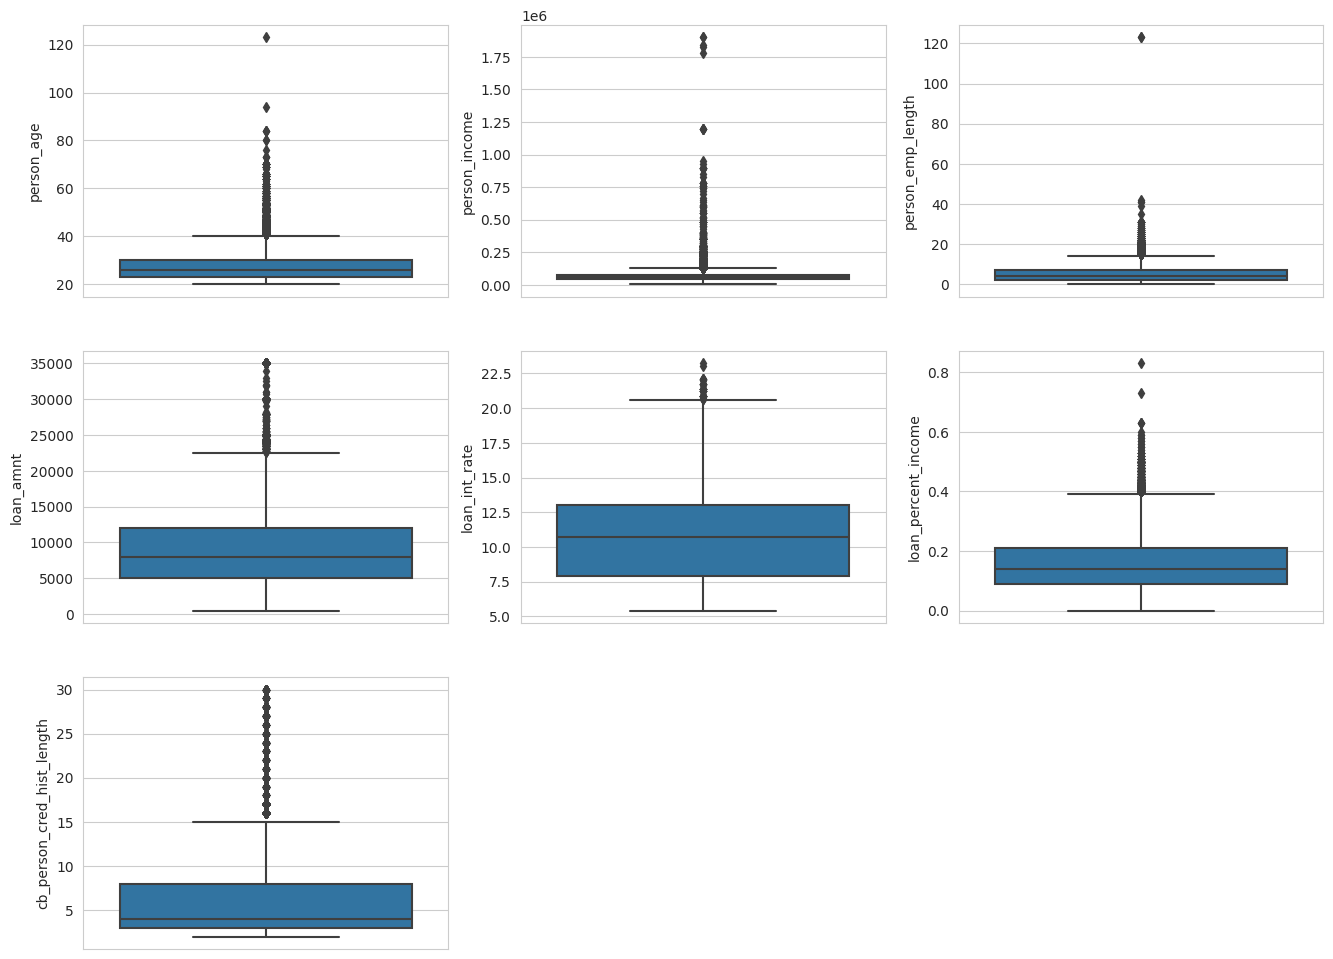

In [17]:
#Box plots
plt.figure(figsize=(16,12))
sns.set_style(style='whitegrid')
plt.subplot(3,3,1)
sns.boxplot(y='person_age',data=df)
plt.subplot(3,3,2)
sns.boxplot(y='person_income',data=df)
plt.subplot(3,3,3)
sns.boxplot(y='person_emp_length',data=df)
plt.subplot(3,3,4)
sns.boxplot(y='loan_amnt',data=df)
plt.subplot(3,3,5)
sns.boxplot(y='loan_int_rate',data=df)
plt.subplot(3,3,6)
sns.boxplot(y='loan_percent_income',data=df)
plt.subplot(3,3,7)
sns.boxplot(y='cb_person_cred_hist_length',data=df)

In [18]:
#Categorical to numerical
df['cb_person_default_on_file'].replace({'N':1 ,'Y':0},inplace = True)

# Feature Engineering

* **Debt-to-Income Ratio:**

Formula: loan_amnt / person_income

Purpose: Indicates the portion of the borrower’s income that goes toward repaying the loan.

* **Credit Utilization:**

Formula: loan_amnt / cb_person_cred_hist_length

Purpose: Measures the amount of available credit being used by the person.

* **Employment Stability:**

Formula: Categorical feature based on person_emp_length (e.g., <=1 year: Unstable, 2-5 years: Moderately stable, >5 years: Stable)

Purpose: Assesses the stability of the person's employment.

* **Home Ownership Stability:**

Formula: Binary feature based on person_home_ownership (e.g., Rented = 0, Owned = 1)

Purpose: Evaluates the stability and financial security related to home ownership.

* **Interest Rate Spread:**

Formula: loan_int_rate - mean(loan_int_rate)

Purpose: Indicates how the interest rate on a loan deviates from the average rate.

* **Loan Intent Risk:**

Formula: Derived from the default rate per loan_intent category (e.g., higher risk for purposes with higher default rates)

Purpose: Assesses the risk associated with the purpose of the loan.

* **Credit History Ratio:**

Formula: cb_person_cred_hist_length / person_age

Purpose: Measures the length of credit history relative to the person's age.

* **Income Stability:**

Formula: Categorical feature based on person_income (e.g., Low, Medium, High using quantiles)

Purpose: Classifies income stability.

In [19]:
#new_feature
df['Debt-to-Income Ratio'] = (df['loan_amnt'] / df['person_income']).round(4)

In [20]:
#new_feature
df['Credit_Utilization'] = (df['loan_amnt'] / df['cb_person_cred_hist_length']).round(4)

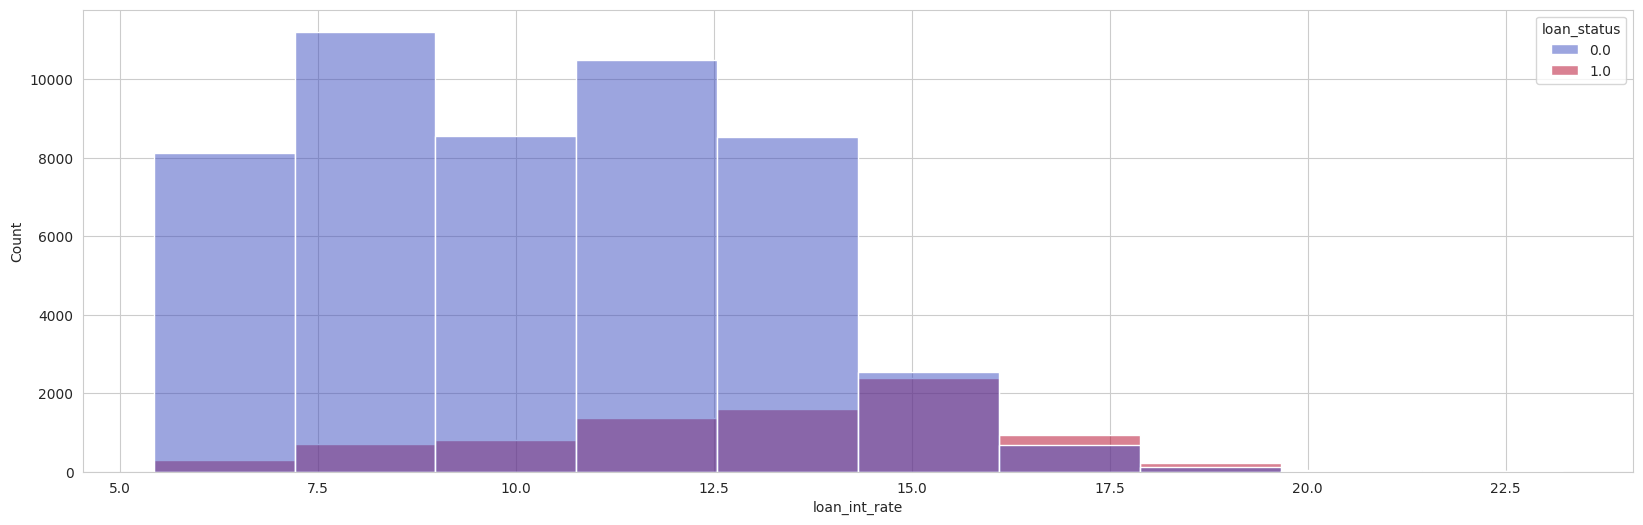

In [21]:
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='loan_int_rate', hue='loan_status', palette='coolwarm',bins=10 );

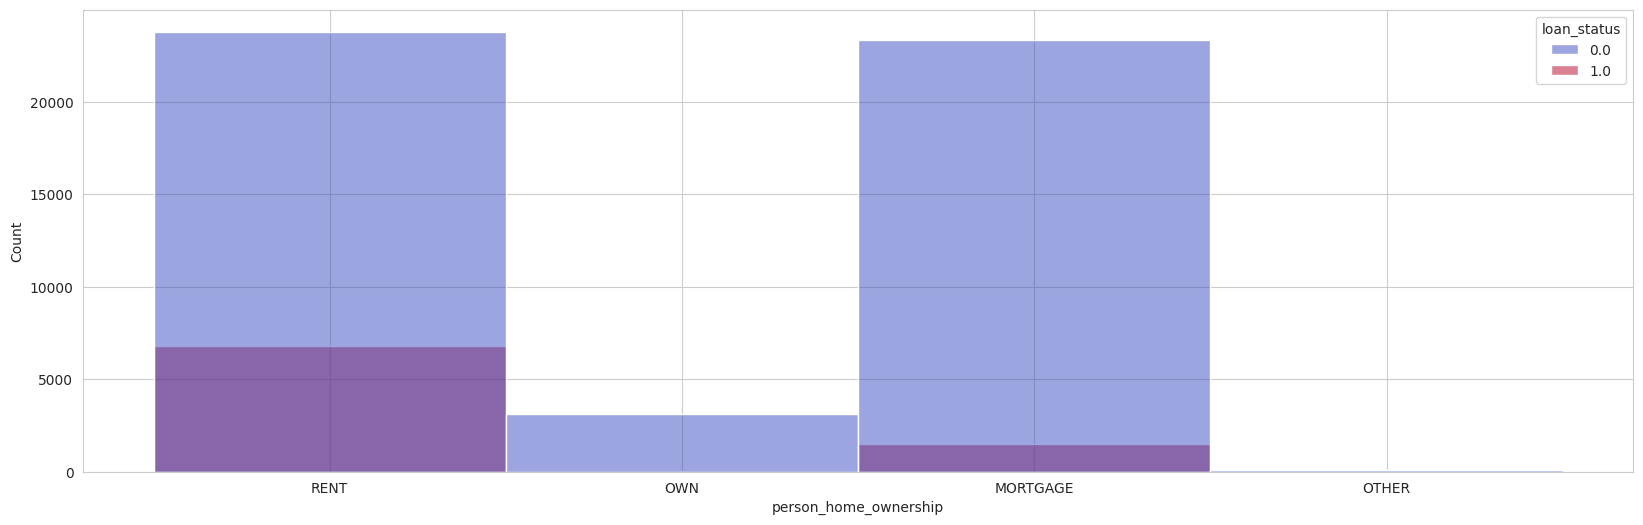

In [22]:
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='person_home_ownership', hue='loan_status', palette='coolwarm',bins=10 );

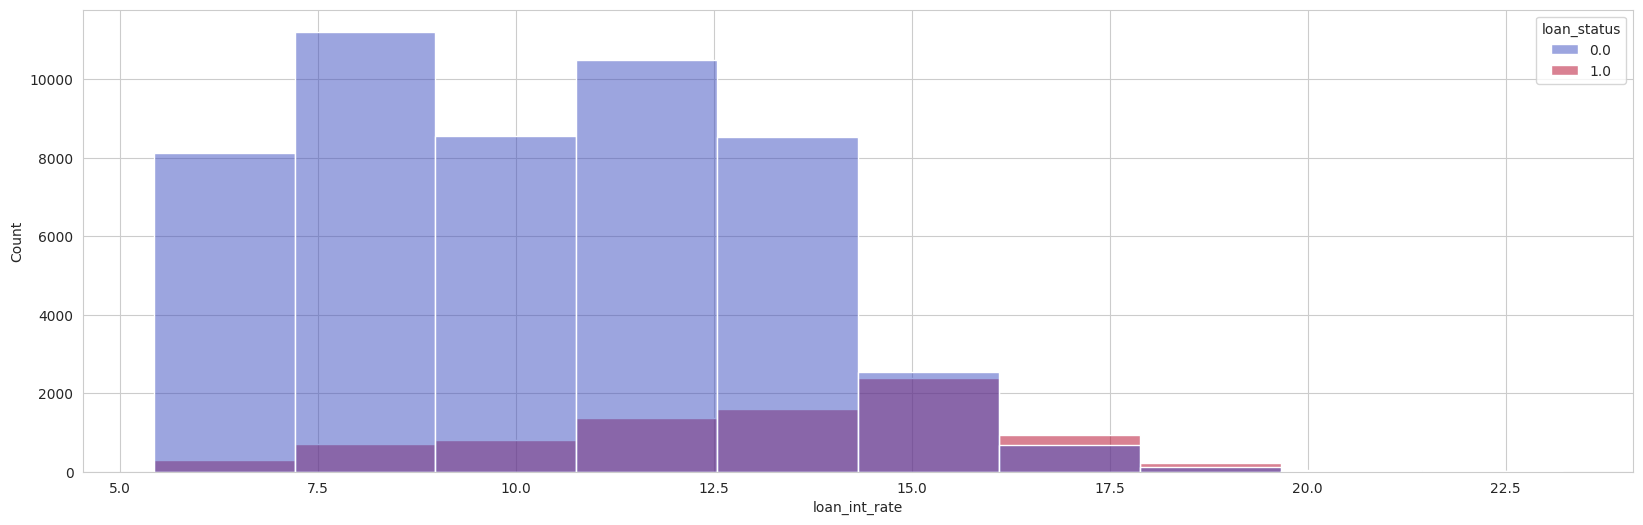

In [23]:
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='loan_int_rate', hue='loan_status', palette='coolwarm',bins=10 );

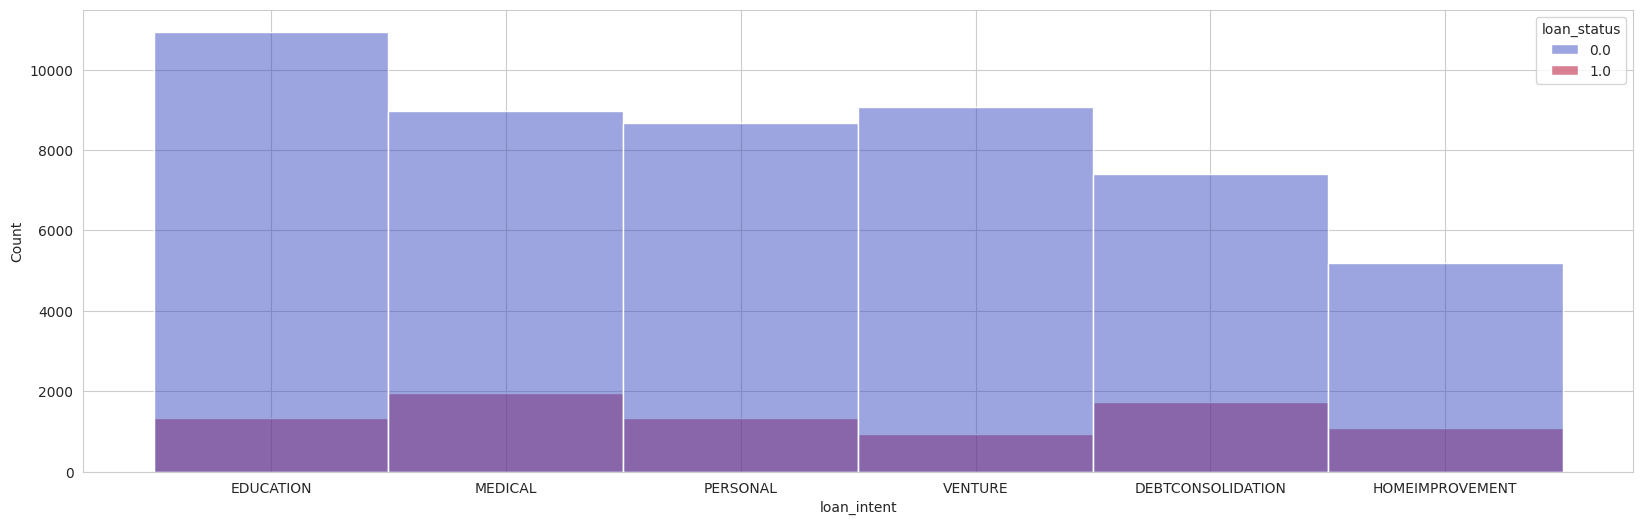

In [24]:
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='loan_intent', hue='loan_status', palette='coolwarm',bins=10 );

In [25]:
#Loan grade tells about quality of loan
loan_grade_mapping = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7
}
df['loan_grade_ordinal'] = df['loan_grade'].map(loan_grade_mapping)

In [26]:
df.drop(columns = ['loan_grade'], inplace = True)

In [27]:
categorical_columns = [col for col in df.columns if df[col].dtype =='O']

In [28]:
categorical_columns

['person_home_ownership', 'loan_intent']

In [29]:
df = pd.get_dummies(df, columns=['person_home_ownership'], drop_first = True)

In [30]:
df = pd.get_dummies(df, columns=['loan_intent'], drop_first = True)

In [31]:
df.replace({True:1 ,False:0},inplace = True)

In [32]:
# Drop the row(s) with the maximum person_age as 123 years is single outlier
df.drop(df[df['person_age'] == df['person_age'].max()].index, inplace=True)

In [33]:
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,Debt-to-Income Ratio,Credit_Utilization,loan_grade_ordinal,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,37,35000,0.0,6000,11.49,0.17,1,14,0.0,0.1714,428.5714,2,0,0,1,1,0,0,0,0
1,22,56000,6.0,4000,13.35,0.07,1,2,0.0,0.0714,2000.0000,3,0,1,0,0,0,1,0,0
2,29,28800,8.0,6000,8.90,0.21,1,10,0.0,0.2083,600.0000,1,0,1,0,0,0,0,1,0
3,30,70000,14.0,12000,11.11,0.17,1,5,0.0,0.1714,2400.0000,2,0,0,1,0,0,0,0,1
4,22,60000,2.0,6000,6.92,0.10,1,3,0.0,0.1000,2000.0000,1,0,0,1,0,0,1,0,0


In [34]:
x= df.drop(columns = 'loan_status') 
y= df['loan_status']

In [35]:
y.dropna(inplace = True)

In [36]:
ss=StandardScaler()
x_scaled = ss.fit_transform(x)

In [37]:
x_scaled_df = pd.DataFrame(x_scaled, columns=x.columns)

In [38]:
x_scaled_df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,Debt-to-Income Ratio,Credit_Utilization,loan_grade_ordinal,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,1.567355,-0.765726,-1.196752,-0.580225,0.270325,0.115944,0.418595,2.021433,0.120626,-0.933375,-0.061981,-0.041494,-0.236901,0.959821,1.950322,-0.346792,-0.481261,-0.456074,-0.453010
1,-0.922156,-0.212231,0.332509,-0.939370,0.884407,-0.974948,0.418595,-0.944152,-0.934357,-0.150668,0.896285,-0.041494,4.221167,-1.041861,-0.512736,-0.346792,2.077873,-0.456074,-0.453010
2,0.239615,-0.929139,0.842263,-0.580225,-0.584768,0.552301,0.418595,1.032904,0.509915,-0.847989,-1.020247,-0.041494,4.221167,-1.041861,-0.512736,-0.346792,-0.481261,2.192625,-0.453010
3,0.405583,0.156766,2.371525,0.497210,0.144867,0.115944,0.418595,-0.202756,0.120626,0.048566,-0.061981,-0.041494,-0.236901,0.959821,-0.512736,-0.346792,-0.481261,-0.456074,2.207455
4,-0.922156,-0.106803,-0.686998,-0.580225,-1.238469,-0.647680,0.418595,-0.697020,-0.632632,-0.150668,-1.020247,-0.041494,-0.236901,0.959821,-0.512736,-0.346792,2.077873,-0.456074,-0.453010


In [39]:
x.drop(columns = ['Debt-to-Income Ratio','loan_amnt','Credit_Utilization'], inplace = True)

In [40]:
#seperating training and test data
train_data = x.iloc[:58644]
test_data = x.iloc[58644:]

In [41]:
#splitting the data
x_train , x_test , y_train, y_test = train_test_split(train_data, y, test_size=0.2,random_state=42 )

In [42]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)

0.9535339756159945

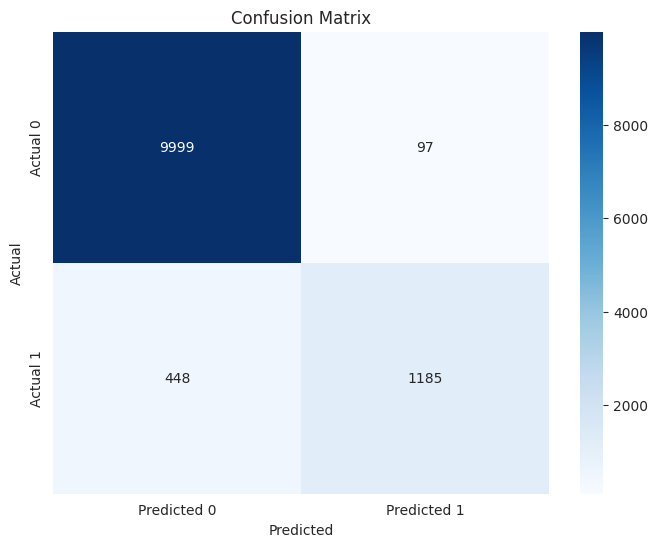

In [44]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [47]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu", input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(90, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test))

In [50]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8647 - loss: 0.3966
Test Accuracy: 0.8608


In [114]:
import xgboost as xgb

In [115]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [116]:
y_pred1 = xgb_clf.predict(x_test)
accuracy_score(y_test, y_pred1)

0.9535339756159945

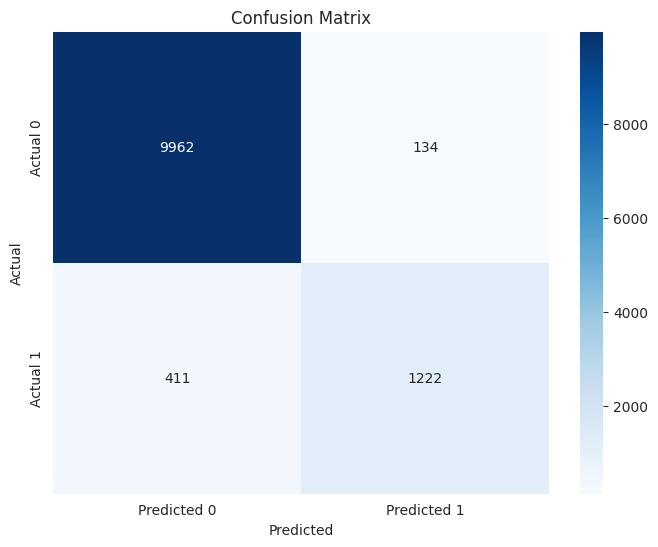

In [117]:
cm = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [118]:
log_reg = LogisticRegression()
log_reg.fit (x_train, y_train)

LogisticRegression()

In [119]:
y_pred2 = log_reg.predict(x_test)
accuracy_score(y_test, y_pred2)

0.8607724443686589

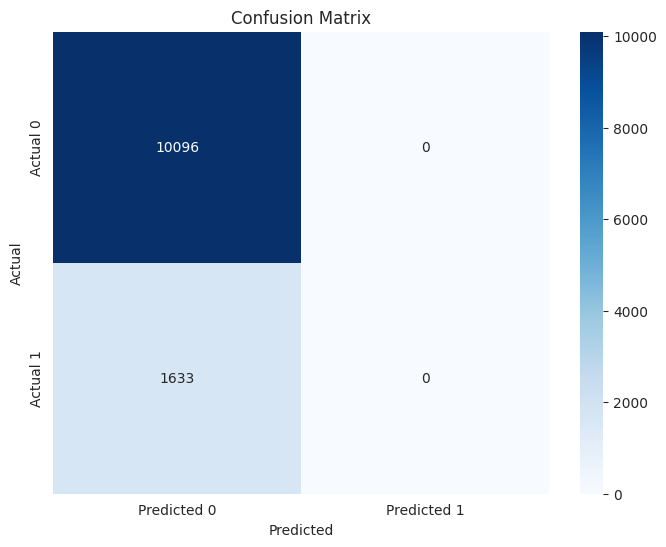

In [120]:
cm = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [121]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)

GradientBoostingClassifier()

In [122]:
y_pred3 = gbc.predict(x_test)
accuracy_score(y_test, y_pred3)

0.9474806036320232

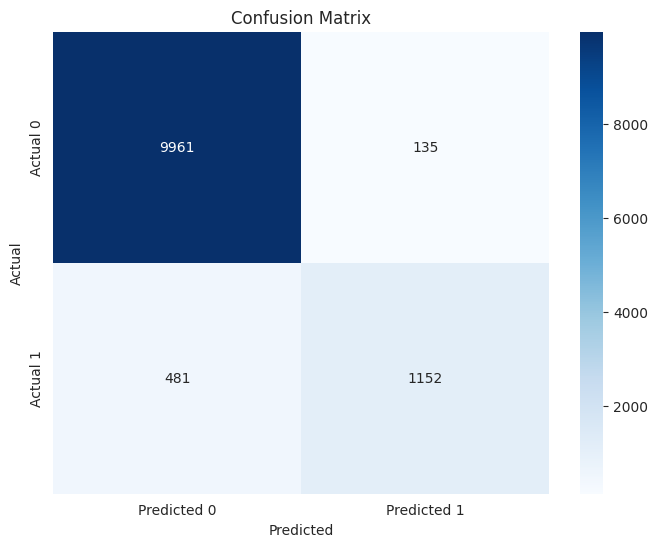

In [123]:
cm = confusion_matrix(y_test, y_pred3)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [124]:
abc = AdaBoostClassifier(n_estimators=100, random_state=42)
abc.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [125]:
y_pred4 = abc.predict(x_test)
accuracy_score(y_test, y_pred4)

0.9289794526387586

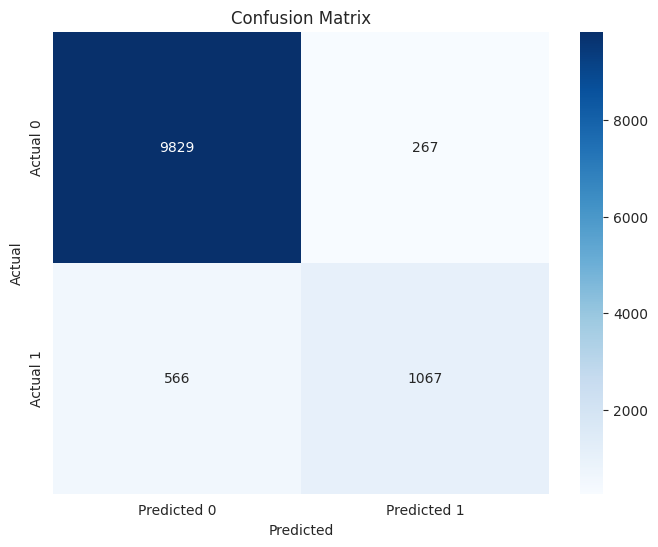

In [126]:
cm = confusion_matrix(y_test, y_pred4)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [127]:
bagging_clf =BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bagging_clf.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=42)

In [128]:
y_pred5 = bagging_clf.predict(x_test)
accuracy_score(y_test, y_pred5)

0.9516582828885668

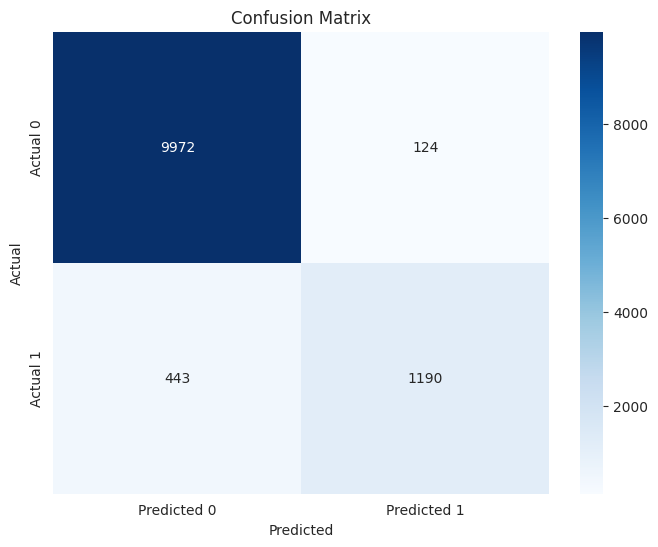

In [129]:
cm = confusion_matrix(y_test, y_pred5)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

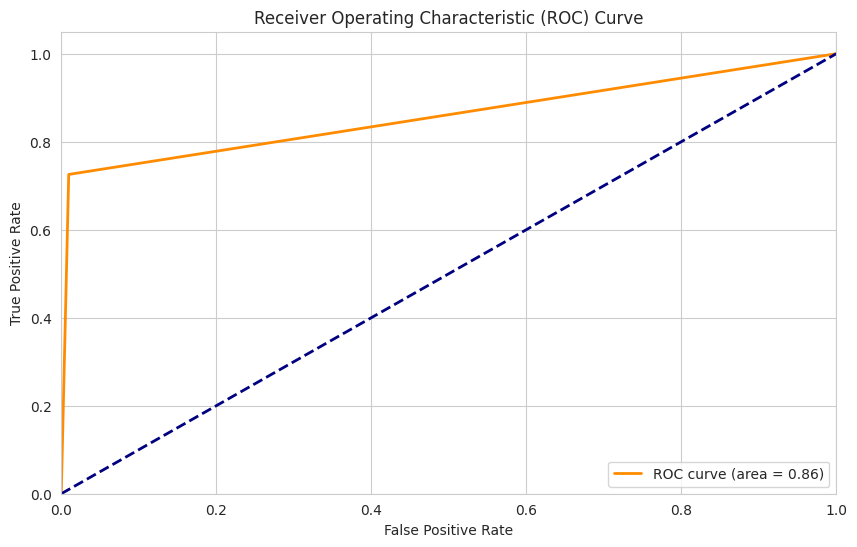

In [130]:
# Compute ROC curve and ROC area for random forest
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Best results are found by XG Boost, Lets do parameter tuning here for complete data set.**

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 10],
    'n_estimators': [100, 200],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1.0]
}

In [ ]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='accuracy')
grid_search.fit(train_data, y)

In [ ]:
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

In [ ]:
model = xgb.XGBClassifier(**best_params)

In [ ]:
model.fit(train_data, y)

In [ ]:
y_predict_test = model.predict(test_data)

In [ ]:
y_pred_proba = model.predict_proba(test_data)[:, 1]

In [ ]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")
sub['loan_status'] = y_pred_proba
print(sub)
sub.to_csv("submission.csv", index=False)

In [ ]:
""""# Import Library
from sklearn.neural_network import MLPClassifier

# Fitting Model
mlp = MLPClassifier(hidden_layer_sizes=(5), activation = 'relu', solver = 'adam',max_iter= 10000, verbose = True)
mlp = mlp.fit(train_data,y)

# Prediction to Test Dataset
y_predmlp = mlp.predict(test_data)"""

In [ ]:
""""y_pred_proba = mlp.predict_proba(test_data)[:, 1]"""

In [ ]:
""""sub = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")
sub['loan_status'] = y_pred_proba
print(sub)
sub.to_csv("submission.csv", index=False)"""